 ## Import Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Ingestion files

### Testutility file

In [3]:
%%writefile testutility.py
import logging
import os
import subprocess
import yaml 
import pandas as pd
import datetime
import gc
import re

#################
# File Reading #
#################

def read_config_file(filepath):
  with open(filepath, "r") as stream:
    try:
      return yaml.safe_load(stream)
    except yaml.YAMLError as exc:
      logging.error(exc)

Overwriting testutility.py


### Yaml file

In [4]:
%%writefile file.yaml
file_type: csv
dataset_name: testfile
file_name: bank-additional-full
table_name: edsurv
inbound_delimeter: ";"
outbound_delimeter: "|"

Overwriting file.yaml


## Prepare Data

In [5]:
# Read Config file
import testutility as util
config_data = util.read_config_file("file.yaml")

In [6]:
config_data["file_name"]

'bank-additional-full'

In [7]:
# read the files using config file
file_type = config_data["file_type"]
source_file = "./" + config_data["file_name"] + f".{file_type}"

# print("", source_file)
df = pd.read_csv(source_file, config_data["inbound_delimeter"])

In [8]:
df.shape

(41188, 21)

In [9]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [11]:
import os
def summary(df, source_file):
    rows = len(df)
    columns = len(df.columns)
    print(f"Number of Rows: {rows}")
    print(f"Number of Columns: {columns}")
    file_size = os.path.getsize(source_file)
    print(f"Size: {file_size} bytes")

In [12]:
summary(df, source_file)

Number of Rows: 41188
Number of Columns: 21
Size: 5834924 bytes


In [13]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [14]:
df.duplicated().sum()

12

Here we have 41k records. So removing record will not affect our existing dataset. So we have drop 12 duplicate records.

In [15]:
df = df.drop_duplicates()

In [16]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [17]:
df.duplicated().sum()

0

In [18]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Now, as per above result,  we can see there is no any duplicate value nor null value.

## Understand Data

### Variable Types

#### Target Variable

In [19]:
target_var = ['y']
target = df[target_var]
target_var

['y']

<AxesSubplot:title={'center':'Target y'}, xlabel='y', ylabel='% outcomes'>

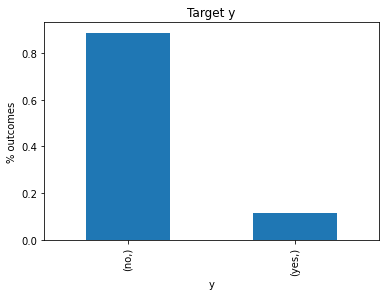

In [20]:
target.value_counts(normalize=True).plot(kind="bar", ylabel = "% outcomes", title = "Target y")

The data suggest an imbalance in the target variable. This can affect the performance of our model so an oversampling technique must be applied before model building. 

#### Categorical Variables

In [21]:
categorical_var = [var for var in df.columns 
                   if df[var].dtype=="O" and 
                   var not in target_var and 
                   var not in ["month"]]
categorical_var

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'day_of_week',
 'poutcome']

In [22]:
# let's explore the values of these categorical variables
for var in categorical_var:
    print(var, df[var].unique())
    print()

job ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

marital ['married' 'single' 'divorced' 'unknown']

education ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

default ['no' 'unknown' 'yes']

housing ['no' 'yes' 'unknown']

loan ['no' 'yes' 'unknown']

contact ['telephone' 'cellular']

day_of_week ['mon' 'tue' 'wed' 'thu' 'fri']

poutcome ['nonexistent' 'failure' 'success']



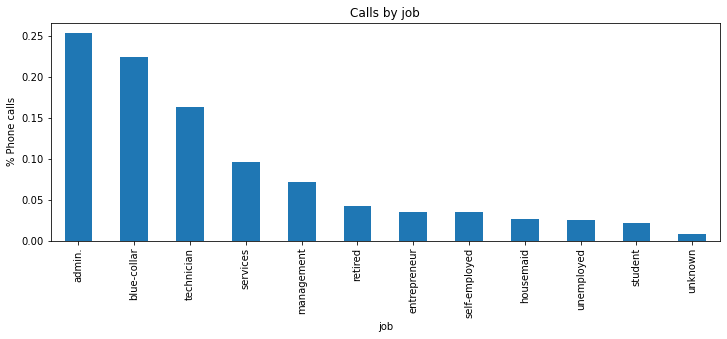

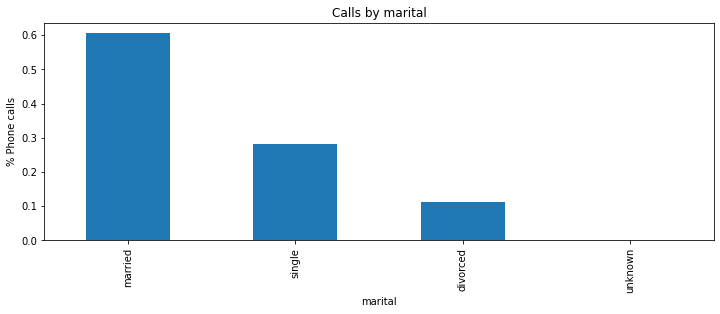

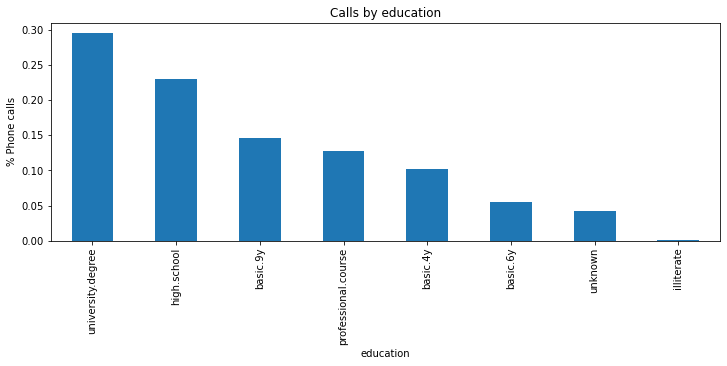

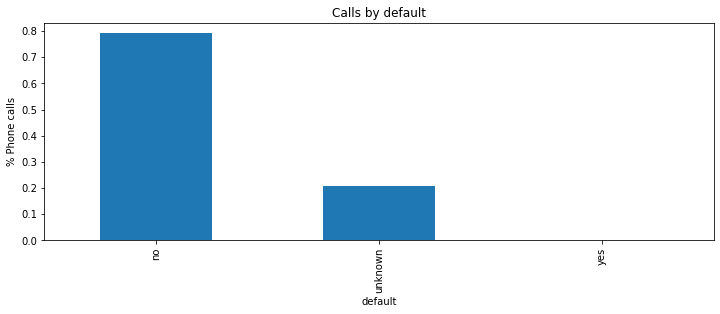

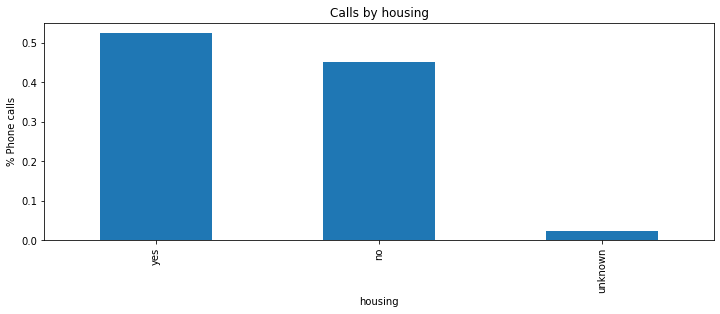

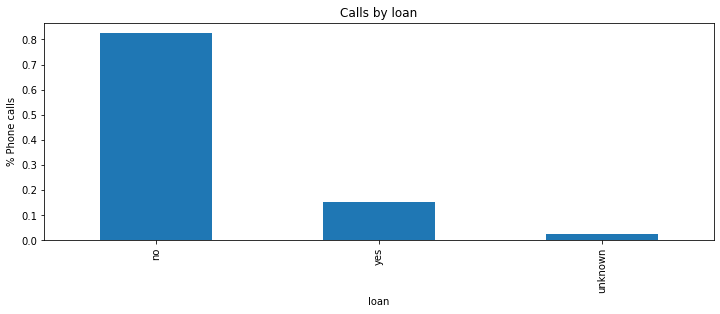

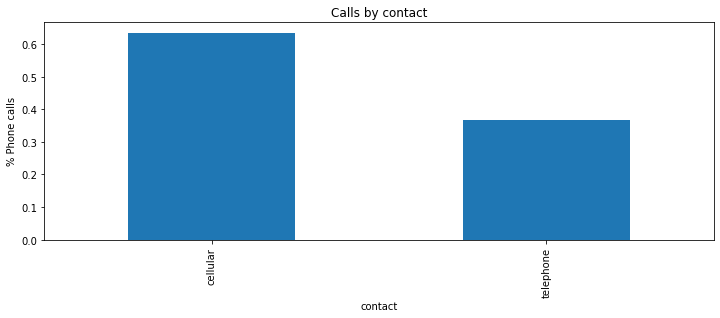

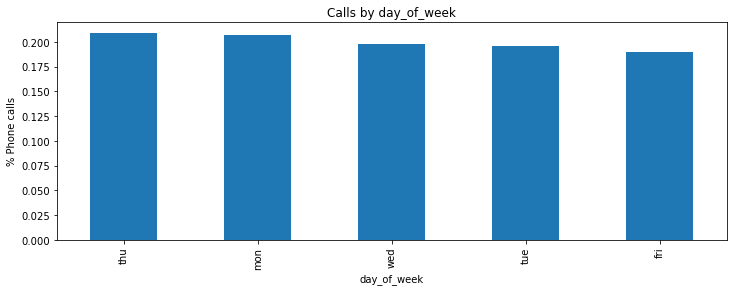

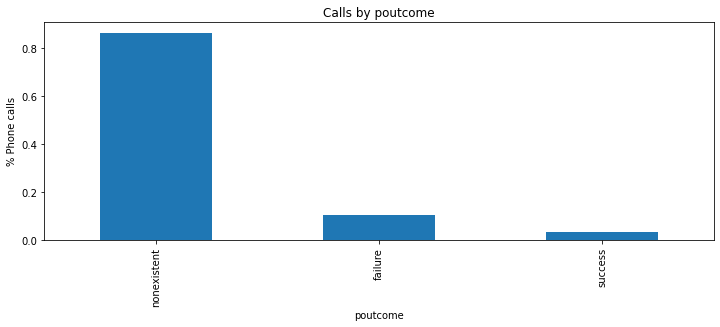

In [23]:
for var in categorical_var:
    
    plt.figure(figsize=(12,4))
    
    # plot transformed variable vs sale price
    df[var].value_counts(normalize = True).plot(
    kind="bar",
    xlabel=f"{var}",
    ylabel="% Phone calls",
    title=f"Calls by {var}"
    )
                
    plt.show()

#### Numeric Variables

In [24]:
numerical_var = [var for var in df.columns if var not in categorical_var + target_var]
numerical_var

['age',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

#### Temporal Variables 

In [25]:
temporal_var = [var for var in df.columns if var =="month" or var=="day_of_week"]
temporal_var

['month', 'day_of_week']

#### Discreete Variable 

In [26]:
discrete_var = [var for var in numerical_var if len(df[var].unique()) < 32 and var not in temporal_var]
discrete_var

['pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'nr.employed']

##### Continuous variables 

In [27]:
# make list of continuous variables
continuous_var = [
    var for var in numerical_var if var not in discrete_var+temporal_var]
continuous_var

['age', 'duration', 'campaign', 'euribor3m']

In [28]:
# let's explore the values of these temporal variables

for var in continuous_var:
    print(var, df[var].unique())
    print()

age [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]

duration [ 261  149  226 ... 1246 1556 1868]

campaign [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]

euribor3m [4.857 4.856 4.855 4.859 4.86  4.858 4.864 4.865 4.866 4.967 4.961 4.959
 4.958 4.96  4.962 4.955 4.947 4.956 4.966 4.963 4.957 4.968 4.97  4.965
 4.964 5.045 5.    4.936 4.921 4.918 4.912 4.827 4.794 4.76  4.733 4.7
 4.663 4.592 4.474 4.406 4.343 4.286 4.245 4.223 4.191 4.153 4.12  4.076
 4.021 3.901 3.879 3.853 3.816 3.743 3.669 3.563 3.488 3.428 3.329 3.282
 3.053 1.811 1.799 1.778 1.757 1.726 1.703 1.687 1.663 1.65  1.64  1.629
 1.614 1.602 1.584 1.574 1.56  1.556 1.548 1.538 1.531 1.52  1.51  1.498
 1.483 1.479 1.466 1.453 1.445 1.435 1.423 1.415 1.4

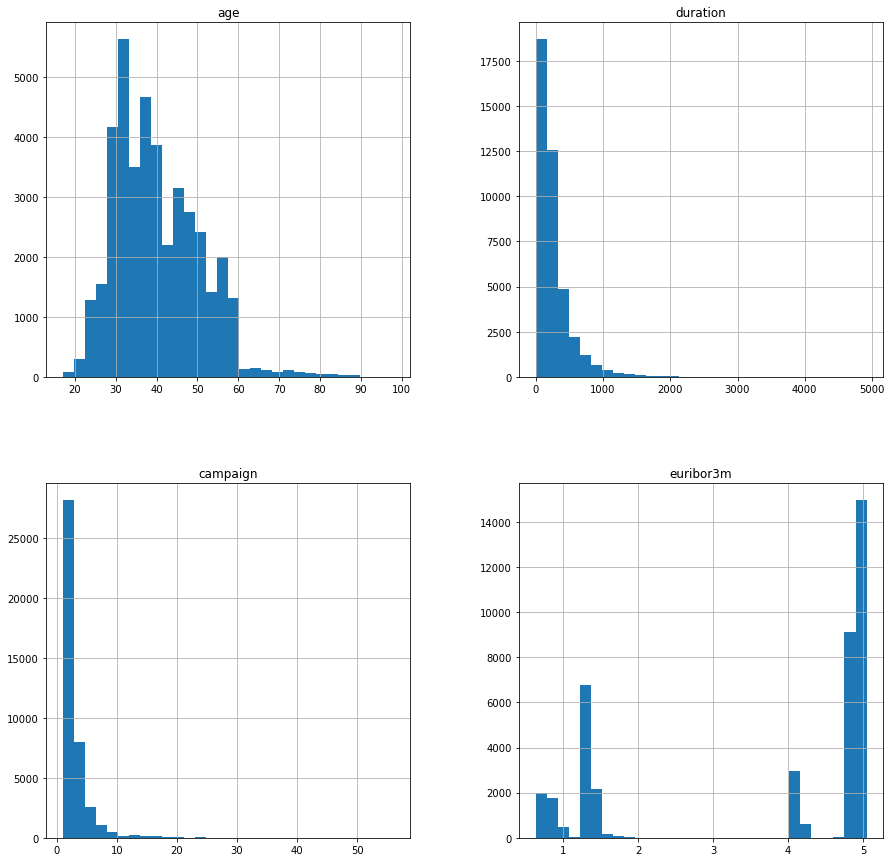

In [29]:
# lets plot histograms for all continuous variables
df[continuous_var].hist(bins=30, figsize=(15,15))
plt.show()

In [30]:
# let's explore the values of these discrete variables

for var in discrete_var:
    print(var, df[var].unique())
    print()

pdays [999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]

previous [0 1 2 3 4 5 6 7]

emp.var.rate [ 1.1  1.4 -0.1 -0.2 -1.8 -2.9 -3.4 -3.  -1.7 -1.1]

cons.price.idx [93.994 94.465 93.918 93.444 93.798 93.2   92.756 92.843 93.075 92.893
 92.963 92.469 92.201 92.379 92.431 92.649 92.713 93.369 93.749 93.876
 94.055 94.215 94.027 94.199 94.601 94.767]

cons.conf.idx [-36.4 -41.8 -42.7 -36.1 -40.4 -42.  -45.9 -50.  -47.1 -46.2 -40.8 -33.6
 -31.4 -29.8 -26.9 -30.1 -33.  -34.8 -34.6 -40.  -39.8 -40.3 -38.3 -37.5
 -49.5 -50.8]

nr.employed [5191.  5228.1 5195.8 5176.3 5099.1 5076.2 5017.5 5023.5 5008.7 4991.6
 4963.6]



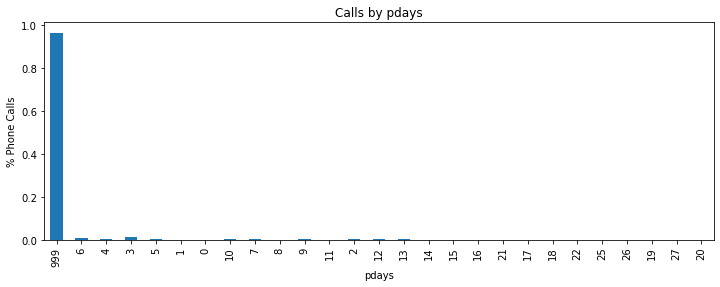

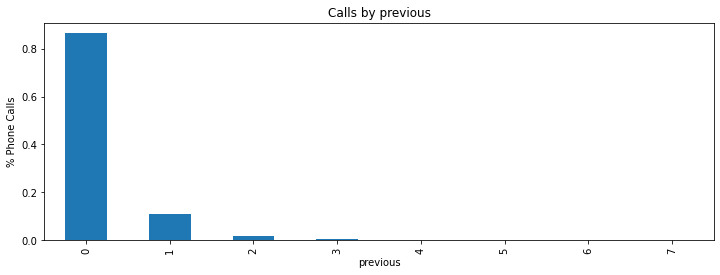

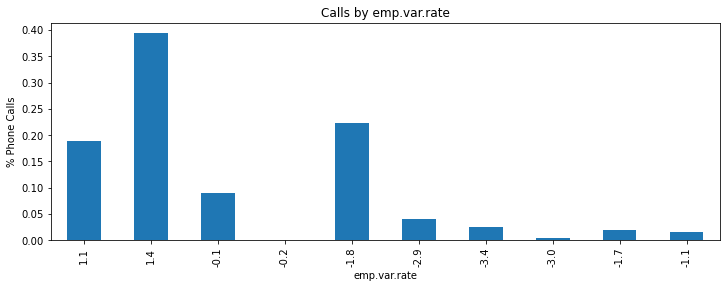

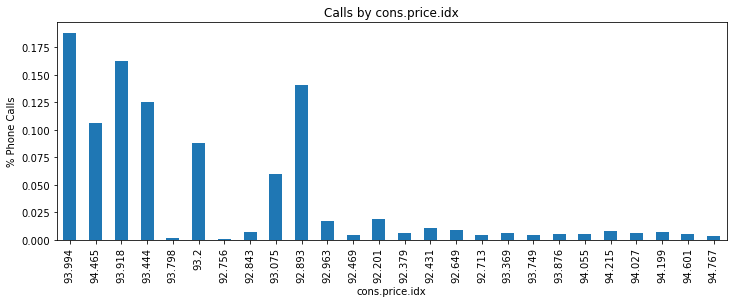

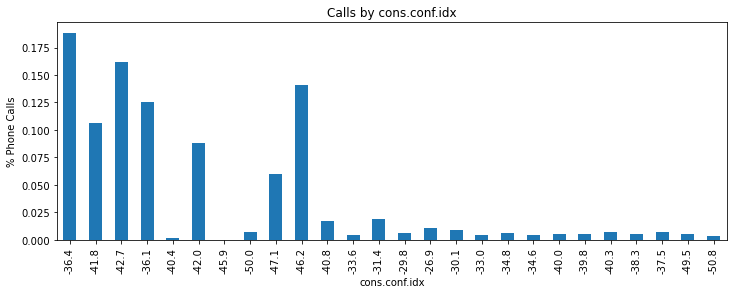

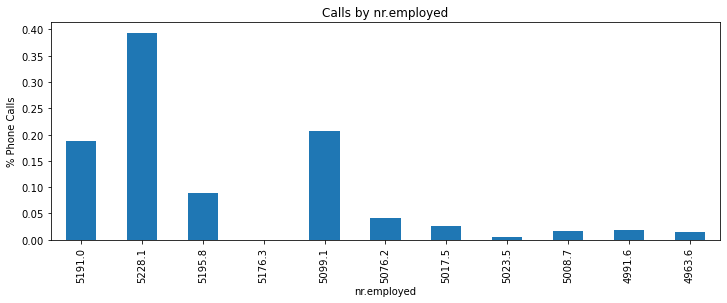

In [31]:
for var in discrete_var:
    
    plt.figure(figsize=(12,4))
    
    # plot transformed variable vs sale price
    df[var].value_counts(normalize = True, sort = False).plot(
    kind="bar",
    xlabel=f"{var}",
    ylabel="% Phone Calls",
    title=f"Calls by {var}"
    )
                
    plt.show()

In [32]:
# let's explore the values of these temporal variables

for var in temporal_var:
    print(var, df[var].unique())
    print()

month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

day_of_week ['mon' 'tue' 'wed' 'thu' 'fri']



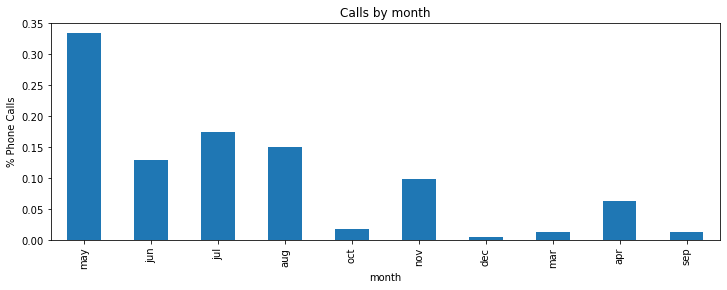

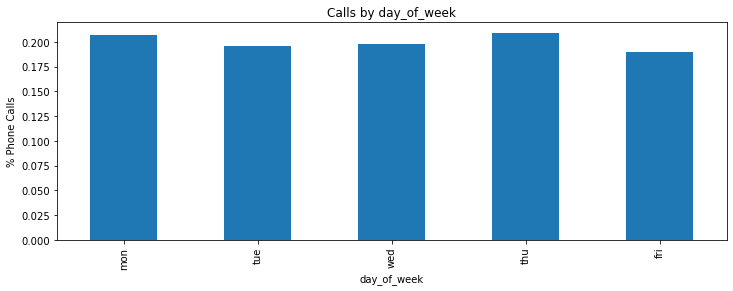

In [33]:
for var in temporal_var:
    
    plt.figure(figsize=(12,4))
    
    # plot transformed variable vs sale price
    df[var].value_counts(normalize = True, sort = False).plot(
    kind="bar",
    xlabel=f"{var}",
    ylabel="% Phone Calls",
    title=f"Calls by {var}"
    )
                
    plt.show()

## Cleaning and Transformation

NOTES:
- Duration is a variable we can explore for business purposes to decide if we should try engaging the person for longer time on the call or not. This variable should not be included in the model becuase Duration is obtained after the call is made to the potential client so if the target client has never received calls, this feature is not very useful.
- month mapped to numerical values and another column of day-month can be generated for EDA in furture.
- No missing values but there are some with unknown values in loan housing etc. Consider deleting them
- There is a 999 value existing in pdays column which should be changed to 0
- Outliers need to be handled
- Age column can be log transformed 

### Missing Values

Fortunately, there are no missing values in the dataset. However, after exploring we find that 5 of the categorical variables have an "unknown" value. Those are the only missing values which do not need to be dealt with for now as the "unknown category is already created for them. However, deleting them will not affect the dataset so much as they constitute a very small proportion of the dataset. So, we will consider deleting them.

### Mapping month column

In [34]:
m = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}

In [35]:
df["month"] = df["month"].map(m)

In [36]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,5,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,5,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,5,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,5,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#### Creating month-day column

In [37]:
df["month-day"] = df['month'].astype('str') + "-" + df['day_of_week'].astype('str')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,month-day
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon
1,57,services,married,high.school,unknown,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon
2,37,services,married,high.school,no,yes,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon
3,40,admin.,married,basic.6y,no,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon
4,56,services,married,high.school,no,no,yes,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon


### pdays column value correction

In [38]:
df['pdays'].mask(df['pdays'] == 999, 0, inplace=True)

In [39]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,month-day
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon
1,57,services,married,high.school,unknown,no,no,telephone,5,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon
2,37,services,married,high.school,no,yes,no,telephone,5,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon
3,40,admin.,married,basic.6y,no,no,no,telephone,5,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon
4,56,services,married,high.school,no,no,yes,telephone,5,mon,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5-mon


# Outlier

we are using box plot method to detect outlier.
Outlier points</b> = Q3 + 1.5 IQR(Upper Quartile) , Q1 - 1.5 IQR(Lower Quartile)

In [40]:
numerical_var

['age',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

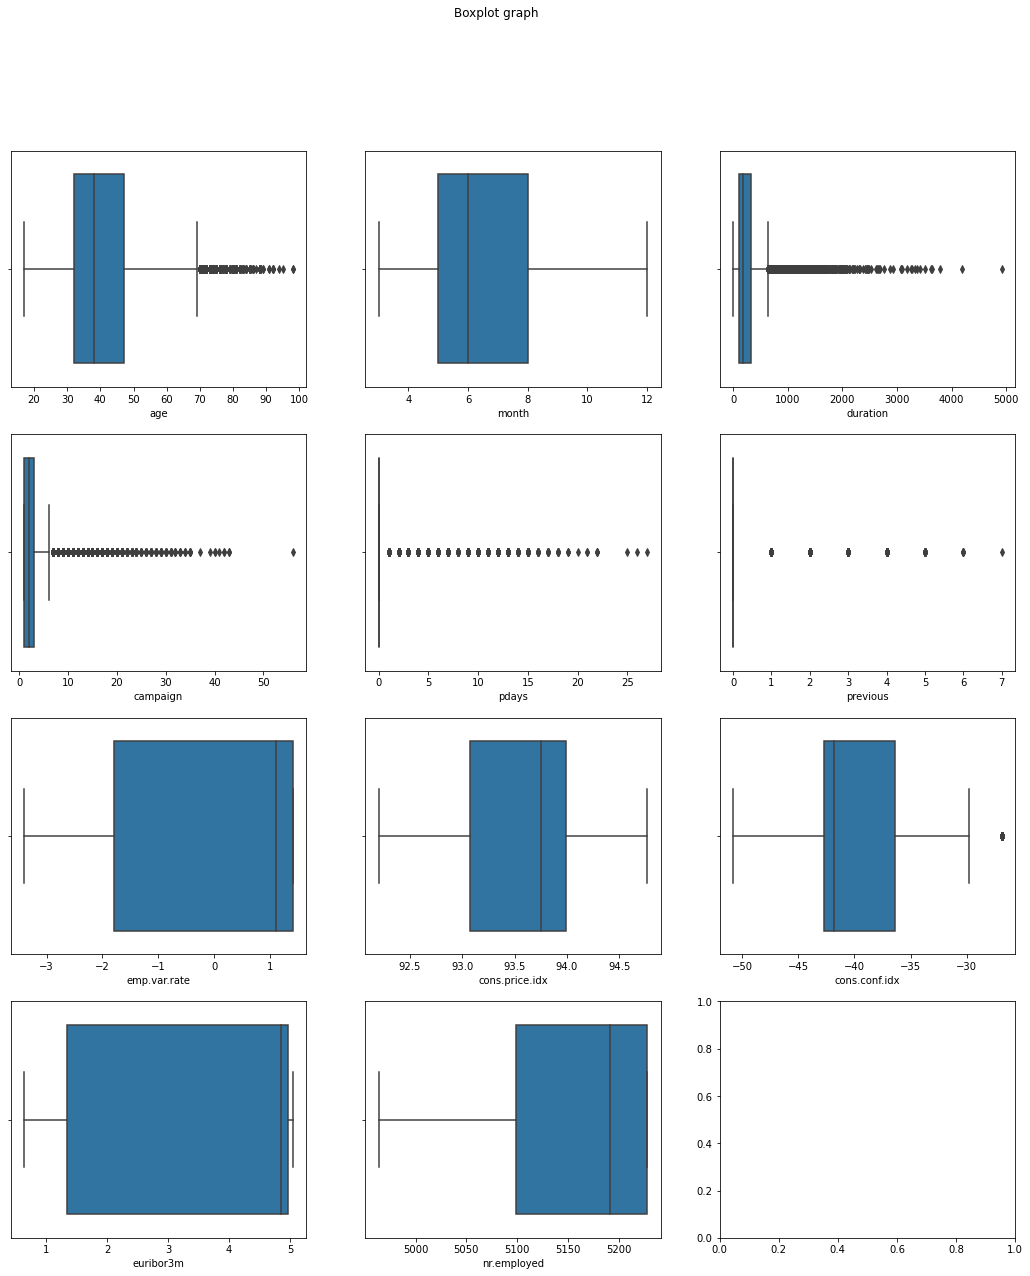

In [41]:
fig,axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Boxplot graph')
count = 0;
for i in range(4):
    for j in range(3):
        if( count < len(numerical_var)):
            sns.boxplot(ax=axes[i,j], x=numerical_var[count], data=df)
            count = count + 1

From the above Boxplot graph, we can clearly see that age, duration, campaign and cons.conf.idx contain outlier. So we can perform opratoin to remove outlier.

In [42]:
# here we have defined generic function to remove outlier from any column with any dataset
def removeOutlier(dataset:pd.DataFrame, column:str, remove: bool, lowerCutoff, upperCutoff):
    Q1 = dataset[column].quantile(lowerCutoff / 100)
    Q3 = dataset[column].quantile(upperCutoff / 100)
    
    IQR = Q3-Q1
    lower_limit = Q1 - IQR*1.5
    upper_limit = Q3 + IQR*1.5
    
    # here, we have tow solution. Ether we can remove the outlier or replace it with upper limit.
    if remove:
        temp = dataset[(dataset[column] < lower_limit) or (dataset[column] > upper_limit)]
    else:
        dataset.loc[dataset[column] < lower_limit, column] = lower_limit 
        dataset.loc[dataset[column] > upper_limit, column] = upper_limit
#         We can also use Replace values of Given column by using np.where() function.
#         dataset[column] = np.where(dataset[column] > upper_limit, upper_limit, dataset[column])

In [43]:
# here lower side there is no outlier but upper side, it is slightly noticable so we are taking 95% data.
removeOutlier(df, 'age', False, 0, 95)

In [44]:
df[df['duration'] > 3500]['duration'].min()

3509

In [45]:
# here lower side there is no outlier but upper side, it is clearly visible that after 3500 the frequency descresed. 
# we replace 3500+ value with 3500 value.
# duration(df, 'duration', False, 0, 95)
upper_limit = 3500
df.loc[df['duration'] > upper_limit, 'duration'] = upper_limit 

In [46]:
df[df['campaign'] > 34]['campaign']

4107     56
4114     39
4139     35
4168     42
5304     42
10431    35
11033    41
11593    37
11769    40
13024    35
13447    43
18684    35
18717    35
18728    43
18754    40
Name: campaign, dtype: int64

In [47]:
# here lower side there is no campaign but upper side, it is clearly visible the gap in value after 35. So we set 35 as cutoff value 
# we replace 3500+ value with 3500 value.
# duration(df, 'duration', False, 0, 95)
upper_limit = 34
df.loc[df['campaign'] > upper_limit, 'campaign'] = upper_limit 

In [48]:
# here lower side there is no outlier but upper side, it is slightly noticable so we are taking 95% data.
upper_limit = -30
df.loc[df['cons.conf.idx'] > upper_limit, 'cons.conf.idx'] = upper_limit 

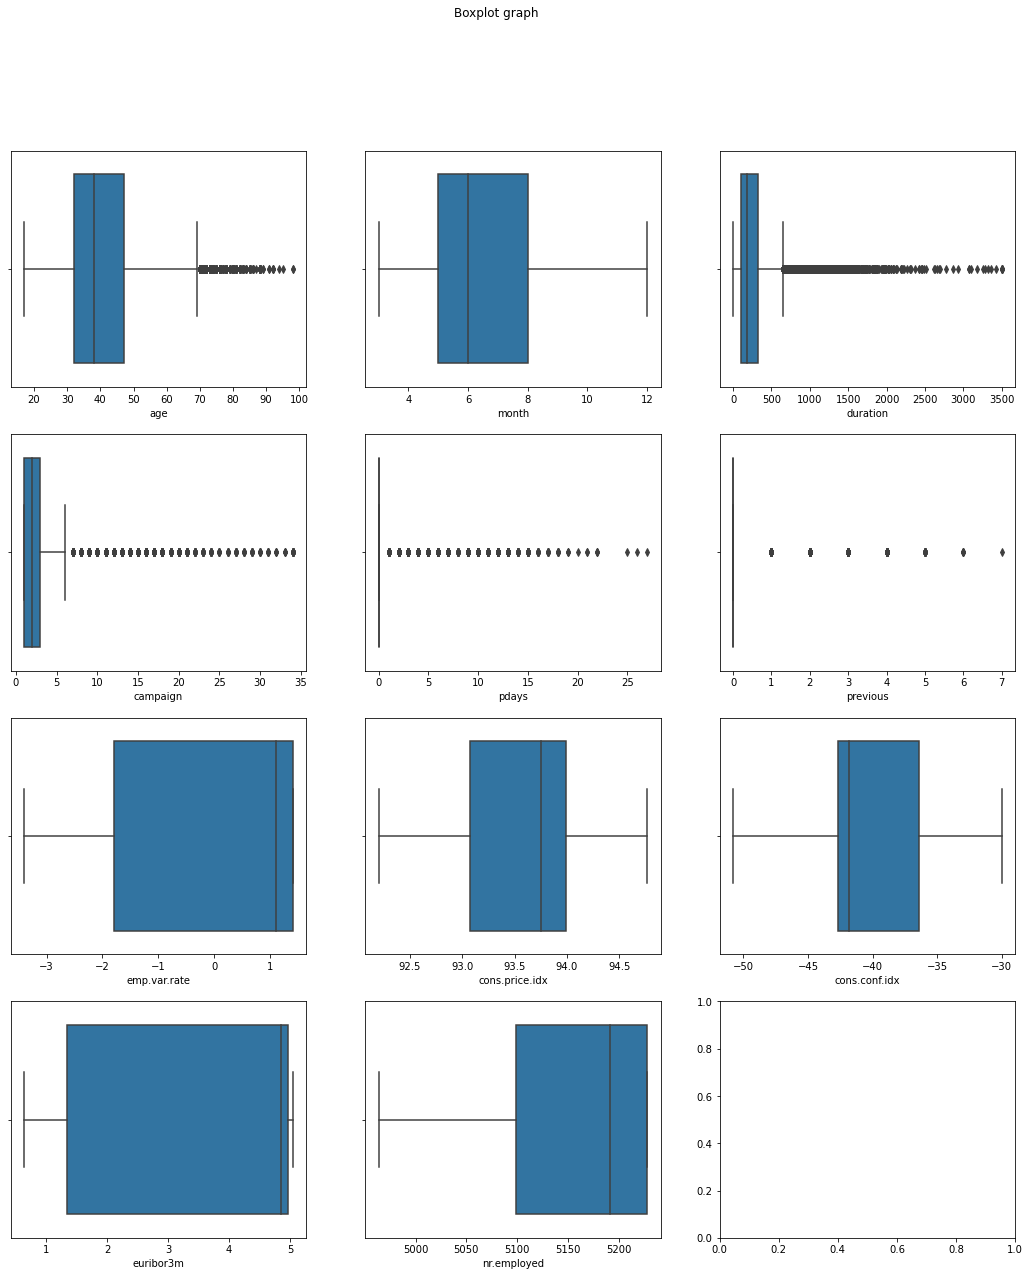

In [49]:
fig,axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Boxplot graph')
count = 0;
for i in range(4):
    for j in range(3):
        if( count < len(numerical_var)):
            sns.boxplot(ax=axes[i,j], x=numerical_var[count], data=df)
            count = count + 1

In above graph, we can see that we have hanlded outlier point at some extent.

In [50]:
import zipfile

list_files = ['file.yaml', 'testutility.py', 'Transformation and cleaning notebook.ipynb', "bank-additional-full.csv"]

with zipfile.ZipFile('final.zip', 'w') as zipF:
    for file in list_files:
        zipF.write(file, compress_type=zipfile.ZIP_DEFLATED)